In [56]:
from qiskit import QuantumCircuit, execute, Aer, QuantumRegister, ClassicalRegister, transpile, assemble
from qiskit.circuit.library.arithmetic.adders.cdkm_ripple_carry_adder import CDKMRippleCarryAdder
from qiskit.quantum_info.operators import Operator
from cmath import exp
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.circuit.library import QFT
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from math import log, ceil
import numpy as np
import classical_maxcut

COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

In [57]:
"""Create graph"""
def generate3RegGraph (number_of_nodes = 6):
    return nx.random_regular_graph(3, number_of_nodes)

In [58]:
"""Generate any circulant graph"""
def circulant_graph(size, connections):
    rtn = nx.Graph()
    rtn.add_nodes_from(range(0,size))
    edges = []
    for distance in connections:
        # edges += [(i, (i+distance)%(size//2)) for i in range(0, size//2)]
        edges += [(i, (i+distance)%(size//2)) for i in range(0, size//2)]
    rtn.add_edges_from(edges)
    return rtn

In [59]:
"""Make diagonal operator and convert to circuit"""
def parameterized_lambda(time, eigenvalues, solution_space_G):
    diagonalized_matrix = []
    for col in range(solution_space_G.number_of_nodes()):
        diagonalized_matrix.append([])
        for row in range(solution_space_G.number_of_nodes()):
            if row == col:
                diagonalized_matrix[-1].append(exp(1j * time * eigenvalues[row]))
            else:
                diagonalized_matrix[-1].append(0)
    return Operator(diagonalized_matrix)

In [60]:
"""Quality function for any graph"""
def quality(solution,graph):
    if len(solution) != graph.number_of_nodes():
        raise RuntimeError('Maxcut potential solution is not encoded correctly.')
    quality = 0
    for i, j in graph.edges():
        if solution[i] != solution[j]:
            quality += 1
    return quality


'''Computes average quality of all the bitstrings outputted by the circuit, accounting for multiplicity'''
def compute_expectation(counts, graph):
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = quality(bitstring, graph)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

In [61]:
def quality_quantum_circuit(graph):
    n = graph.number_of_nodes()
    e = graph.number_of_edges()
    register_size = ceil(log(e,2))
    carry_in = QuantumRegister(1, name="cin")
    problem_register = QuantumRegister(n, name='psi')
    ancilla_register = QuantumRegister(-1 + 2*register_size, name='ancilla')
    carry_out = QuantumRegister(1, name="cout")
    qc = QuantumCircuit(carry_in, problem_register, ancilla_register, carry_out, name = ' quality')
    input_qubits = list(range(n+1, n+register_size))
    output_qubits = list(range(n+register_size, n+2*register_size))
    for (i, j) in graph.edges():
        qc.cx(1+i, 1+j)
        adder = CDKMRippleCarryAdder(register_size)
        qc.append(adder, [0] + [j+1] + input_qubits + output_qubits + [qc.num_qubits-1])
        qc.cx(1+i, 1+j)
    return qc

In [62]:
'''Create exp gates as shown in figure 1 of the paper'''
def exp_gate(i, gamma):
    return Operator(
        [[1, 0],
         [0, exp(-1j * (2**i) * gamma)]]
    )

In [63]:
'''Create a depth 1 QWOA circuit based on input parameters'''
def create_circuit(params, graph, solution_space_graph, eigenvalues):

    """Set up fourier transform gates, look at operator matrix"""
    inv_qft_gate = QFT(graph.number_of_nodes(), inverse=True).to_instruction()  
    qft_gate = QFT(graph.number_of_nodes(), inverse=False).to_instruction()
    qft_matrix = Operator(qft_gate) # to look at columns of the matrix if necessary
    
    # properties
    n = graph.number_of_nodes()
    e = graph.number_of_edges()
    register_size = ceil(log(e,2))

    # extract parameters
    gamma = params[0]
    time = params[1]

    # define circuit
    carry_in = QuantumRegister(1, name="cin")
    problem_register = QuantumRegister(graph.number_of_nodes(), name='phi')
    ancilla_register = QuantumRegister(-1 + 2*ceil(log(graph.number_of_edges(),2)), name='ancilla')
    carry_out = QuantumRegister(1, name="cout")
    output_register = ClassicalRegister(graph.number_of_nodes(), name='output')
    qc = QuantumCircuit(carry_in, problem_register, ancilla_register, output_register, carry_out)
    
    # initialize to a superposition over all valid states (in the case of maxcut, all states are valid)
    for i in range(0, graph.number_of_nodes()):
        qc.h(i)

    qc.barrier()

    # compute quality
    quality_gate = quality_quantum_circuit(graph)#.to_gate()
    qc.append(quality_gate, list(range(0, qc.num_qubits)))
    
    # apply gamma rotation to ancilla qubits
    for i in range(0,register_size):
        unitary = exp_gate(i, gamma)
        qc.append(unitary, [n+register_size+i])
    
    # reapply quality gate
    qc.append(quality_gate, list(range(0, qc.num_qubits)))
    
    qc.barrier()
    
    # quantum fourier transform on the solution phi
    qc.append(qft_gate, list(range(0, graph.number_of_nodes())))
    
    lambda_gate = parameterized_lambda(time, eigenvalues, solution_space_graph)
    qc.append(lambda_gate, list(range(0, graph.number_of_nodes())))

    qc.append(inv_qft_gate, list(range(0, graph.number_of_nodes())))

    qc.measure(list(range(0, graph.number_of_nodes())),list(range(0, graph.number_of_nodes())))

    return qc


In [64]:
def qwoaParameters(initial_parameters_list, graph, connectivity_list, show_graphs=True):
    #Generate the circulant graph used as the solution space
    solution_space_graph = circulant_graph(1 << graph.number_of_nodes(), connectivity_list)

    #Show the graphs if desired
    if show_graphs:
        plt.figure()
        nx.draw_circular(graph, with_labels=True) #Draw the graph
        plt.title("Graph on which to perform maxcut")
        plt.show()
        plt.clf()
        plt.figure(figsize=(15,15)) 
        nx.draw_kamada_kawai(solution_space_graph, with_labels=True) #Draw the solution graph
        plt.title("Circulant solution graph on which to walk")
        plt.show()
        plt.clf()

    return {
        "params": initial_parameters_list, 
        "graph": graph, 
        "solution_space_graph": solution_space_graph, 
        #Generate eigenvalues of circulant graph
        "eigenvalues":np.linalg.eig(nx.adjacency_matrix(solution_space_graph).todense())[0]
        }

In [65]:
"""Simulate circuit and train parameters"""
def runSimulation(initialParametersList, graph, connectivityList):
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = 512

    parameters = qwoaParameters(initialParametersList, graph, connectivityList)
    
    def execute_circ(theta):
        parameters["params"] = theta
        qc = create_circuit(**parameters)
        test = transpile(qc, backend)
        qobj = assemble(test)
        counts = backend.run(qobj, seed_simulator=10, nshots=512).result().get_counts()
        return -compute_expectation(counts, graph)


    res = minimize(execute_circ, initialParametersList, method='COBYLA')
    parameters["params"] = res.x
    qc_res = create_circuit(**parameters)

    test = transpile(qc_res, backend)
    qobj = assemble(test)
    counts = backend.run(qobj, seed_simulator=10).result().get_counts()

    print(classical_maxcut.solve(graph))

    display(plot_histogram(counts,figsize=(25, 15)))

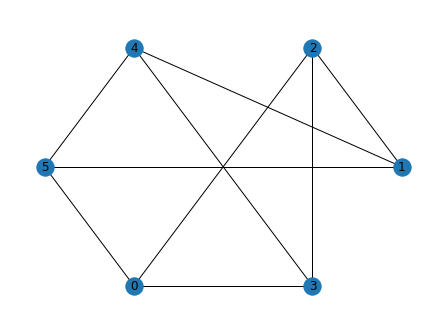

<Figure size 432x288 with 0 Axes>

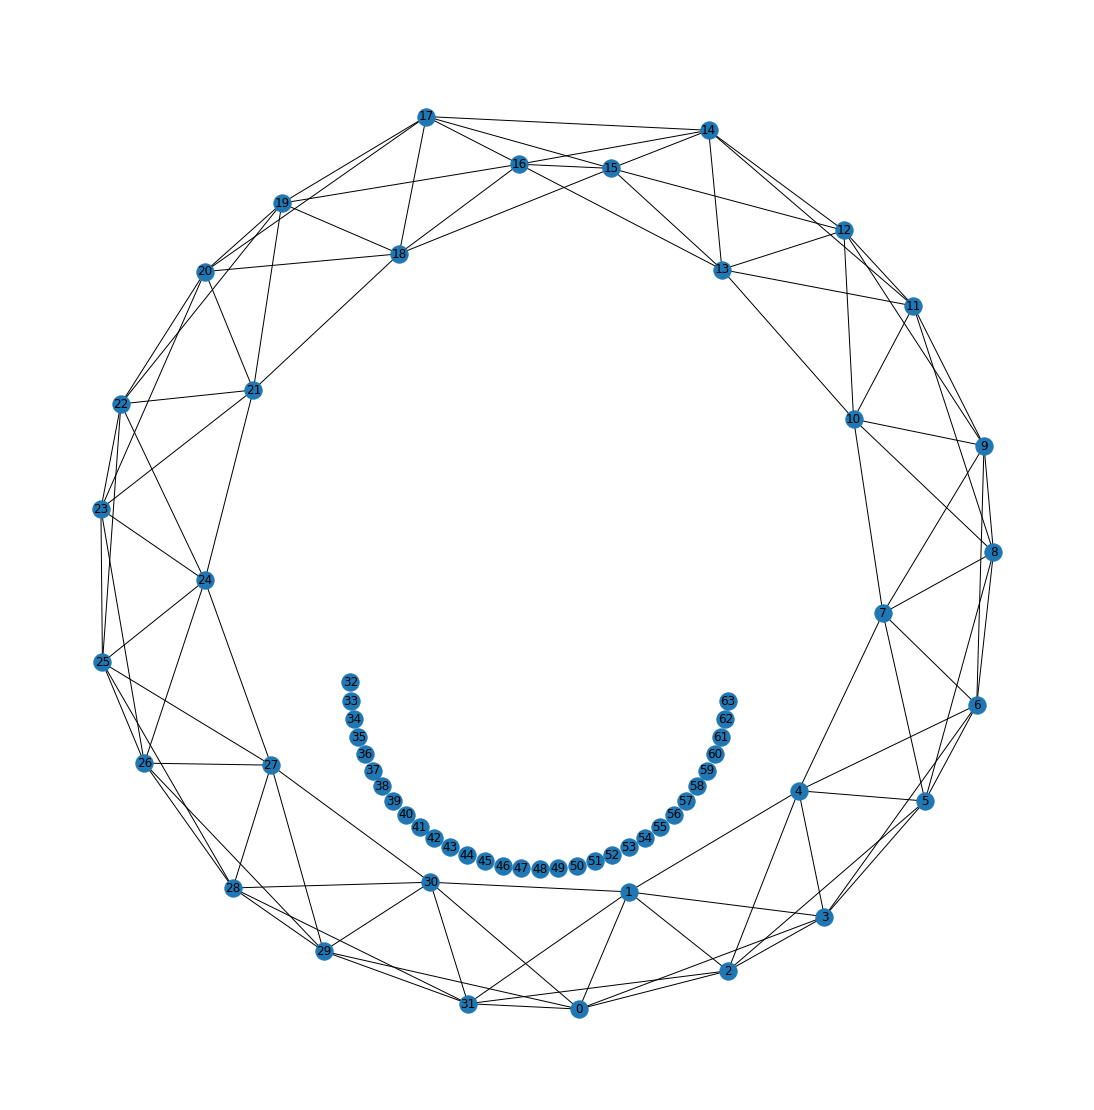

<Figure size 432x288 with 0 Axes>

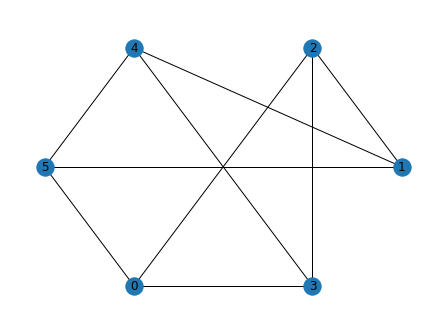

<Figure size 432x288 with 0 Axes>

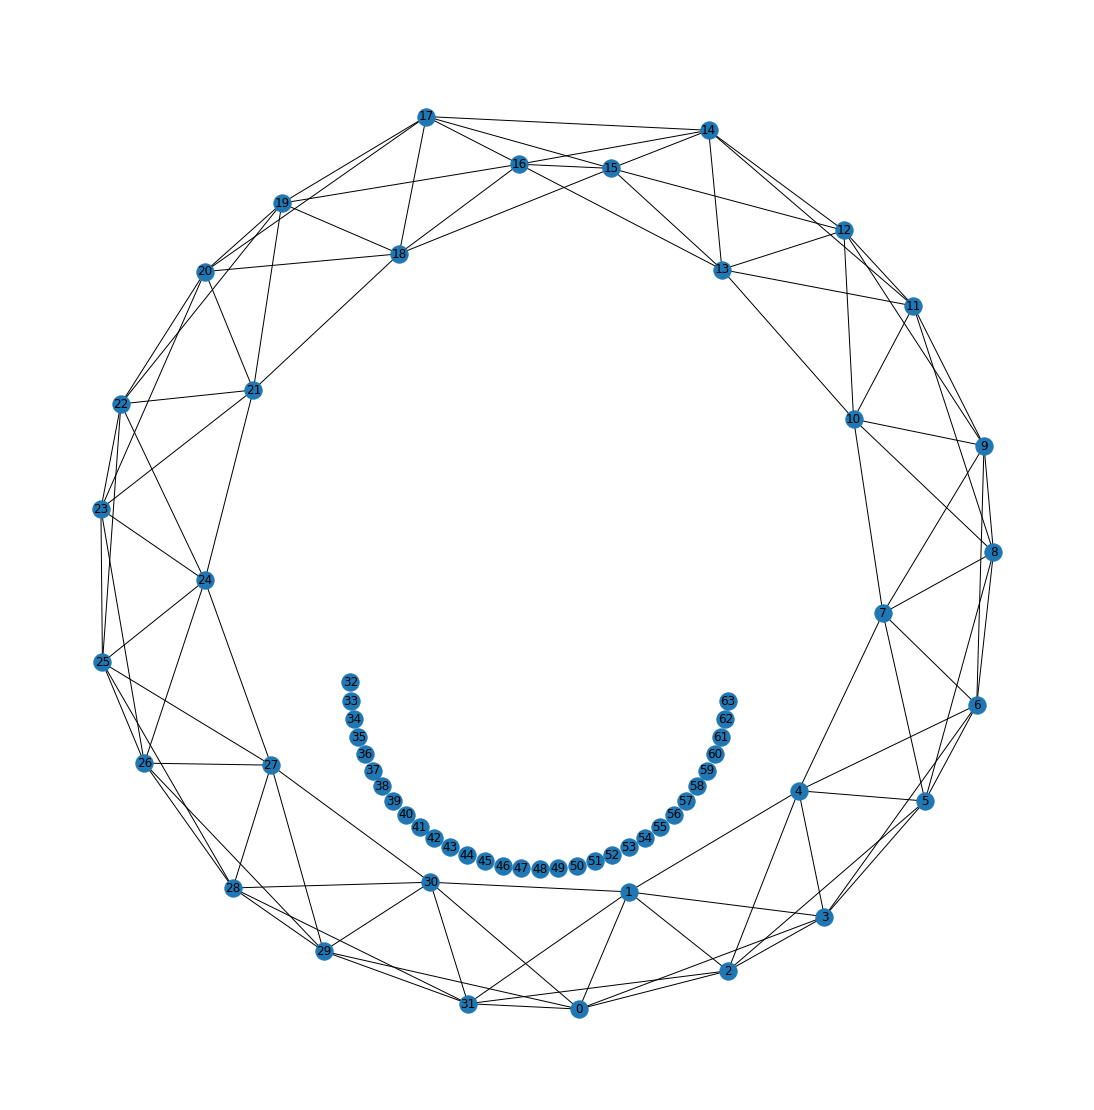

AttributeError: module 'classical_maxcut' has no attribute 'solve'

<Figure size 432x288 with 0 Axes>

In [66]:
graph = generate3RegGraph(6) #6 nodes
connectivityList = [1,2,3]
initialParametersList = [1,1]
parameters = qwoaParameters(initialParametersList, graph, connectivityList, True)
circuit = create_circuit(**parameters)
circuit.draw('mpl')
runSimulation(initialParametersList, graph, connectivityList)